In [97]:
from src.sc import SubtractiveClustering
from src.fcm import FuzzyCMeans
import pandas
import numpy

import matplotlib.pyplot as plt
# %matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = [8, 5]

import warnings
warnings.filterwarnings('ignore')
# numpy.random.seed(0) # makes the random numbers predictable


In [98]:
import cpuinfo
my_cpuinfo = cpuinfo.get_cpu_info()
print(f"Full CPU Name: {my_cpuinfo['brand_raw']}")
print(f"CPU architecture: {my_cpuinfo['arch']}")
import psutil
print(f"Total RAM: {psutil.virtual_memory().total / 1024 / 1024 / 1024:.2f} GB")

Full CPU Name: Intel(R) Pentium(R) Gold G5400 CPU @ 3.70GHz
CPU architecture: X86_64
Total RAM: 15.87 GB


# Subtractive Clustering

In [99]:
data = pandas.read_csv('test/data.csv')
global r1
global r2
r1 = 20; r2 = r1 * 1.15
algorithm = 'Subtractive Clustering'

In [100]:
# Case normalise imto unit hyperbox
norma_data = data.copy()
for i in range(0,data.shape[1]):
        norma_data.iloc[:, i] = (norma_data.iloc[:,i] - norma_data.min(axis = 0)[i])  / (norma_data.max(axis = 0)[i] - norma_data.min(axis = 0)[i])
norma_data = norma_data.to_numpy()
sc = SubtractiveClustering(r1,r2,verbose=False).fit(norma_data)
cntr = sc.centers

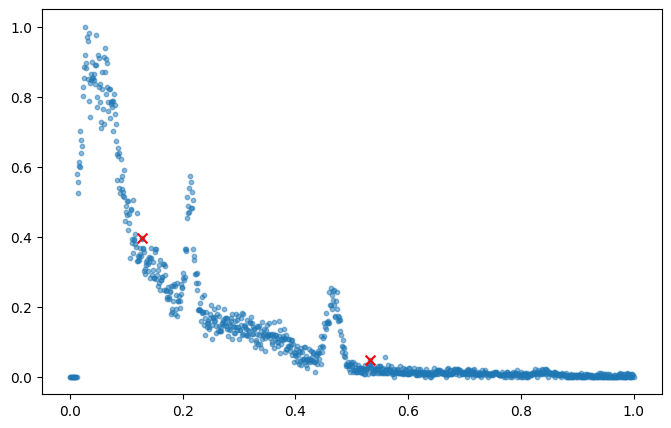

In [101]:
# Plotting
plt.figure()
# Suplottings 
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
plt.scatter([i[0] for i in norma_data], [i[1] for i in norma_data], s = 10, alpha = 0.5)
plt.scatter([i[0] for i in cntr], [i[1] for i in cntr], marker='x', color = 'red', s = 50)
plt.show()

In [102]:
# Case without normalization
sc = SubtractiveClustering(r1,r2).fit(data.to_numpy())
cntr = sc.centers

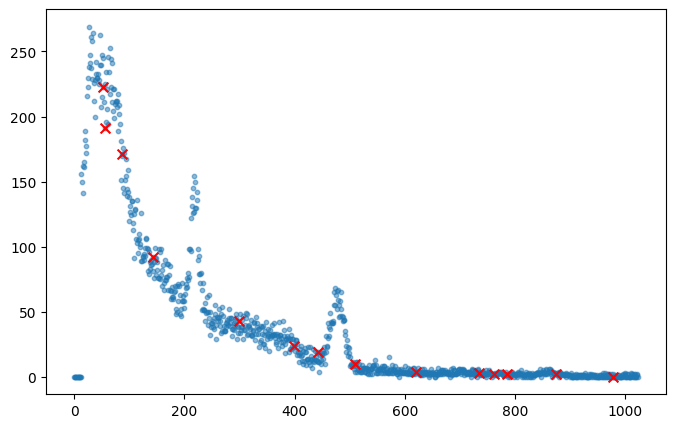

In [103]:
# Plotting
plt.scatter([i[0] for i in data.to_numpy()], [i[1] for i in data.to_numpy()], s = 10, alpha = 0.5)
plt.scatter([i[0] for i in cntr], [i[1] for i in cntr], marker='x', color = 'red', s = 50)
plt.show()

# Fuzzy C-Means Clustering

In [104]:
model = FuzzyCMeans(2, verbose=False)
model.fit(data.to_numpy())
cntr = model.cluster_centers_

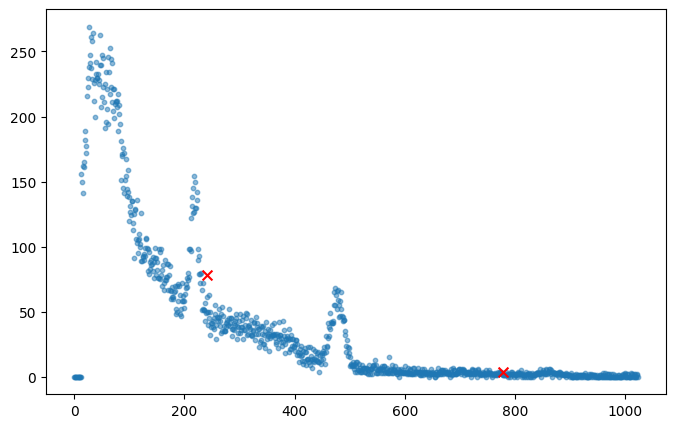

In [105]:
# Plotting
plt.scatter([i[0] for i in data.to_numpy()], [i[1] for i in data.to_numpy()], s = 10, alpha = 0.5)
plt.scatter([i[0] for i in cntr], [i[1] for i in cntr], marker='x', color = 'red', s = 50)
plt.show()

In [106]:
model = FuzzyCMeans(3, verbose=False)
model.fit(norma_data)
cntr = model.cluster_centers_

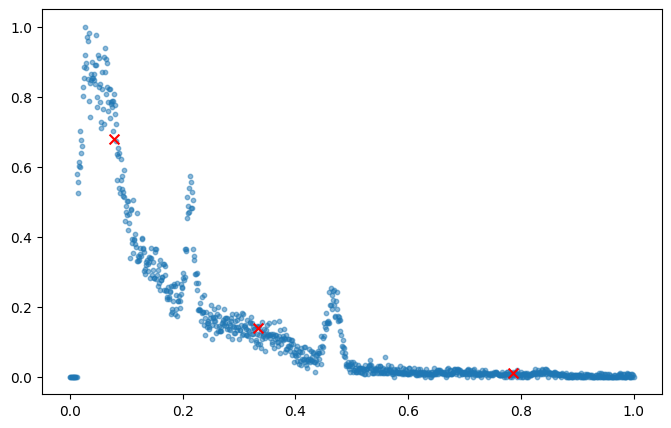

In [107]:
plt.scatter([i[0] for i in norma_data], [i[1] for i in norma_data], s = 10, alpha = 0.5)
plt.scatter([i[0] for i in cntr], [i[1] for i in cntr], marker='x', color = 'red', s = 50)
plt.show()

# SC+FCM (optimization)


In [108]:
# Normalization case
sc = SubtractiveClustering(r1,r2).fit(norma_data)
cntr = sc.centers
l_cntr = len(cntr)
model = FuzzyCMeans(l_cntr, verbose=False)
model.fit(norma_data)
cntr = model.cluster_centers_

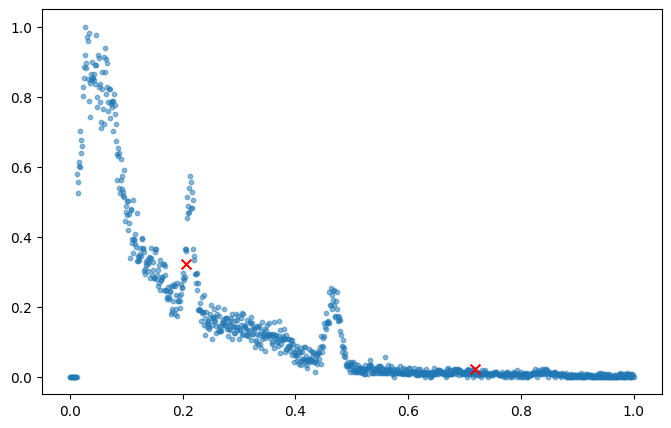

In [109]:
# Plotting
plt.scatter([i[0] for i in norma_data], [i[1] for i in norma_data], s = 10, alpha = 0.5)
plt.scatter([i[0] for i in cntr], [i[1] for i in cntr], marker='x', color = 'red', s = 50)
plt.show()

In [110]:
sc = SubtractiveClustering(r1,r2).fit(data.to_numpy())
cntr = sc.centers
l_cntr = len(cntr)
model = FuzzyCMeans(l_cntr, verbose=False)
model.fit(data.to_numpy())
cntr = model.cluster_centers_
print(r1)

20


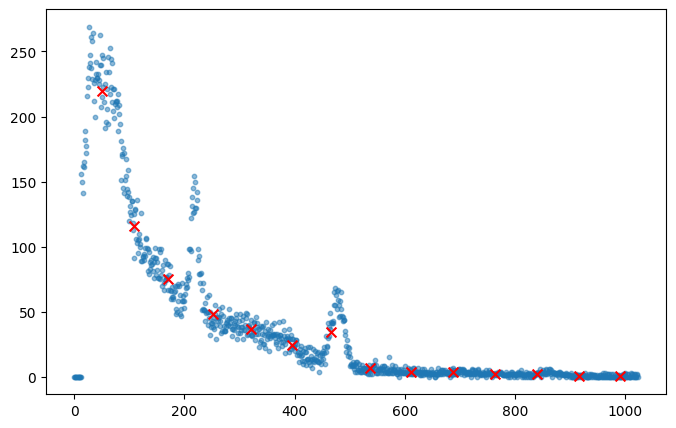

In [111]:
# Plotting
plt.scatter([i[0] for i in data.to_numpy()], [i[1] for i in data.to_numpy()], s = 10, alpha = 0.5)
plt.scatter([i[0] for i in cntr], [i[1] for i in cntr], marker='x', color = 'red', s = 50)
plt.show()